In [4]:
%load_ext autoreload
%autoreload 2

import scipy
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import random
import sir_model
import json
from random import randint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# initialize recording of parameter choices and true/false


# USER: set bounds
beta_search_bounds = [0,1]
gamma_search_bounds = [0,1]

# USER: list how many points for each parameter you'd like to synthesize
beta_values_to_synthesize = 10
gamma_values_to_synthesize = 10

# USER: set values for all parameters that you are not synthesizing 


# USER: set initial conditions
I0, R0 = 0.01, 0
S0 = 1-I0-R0

# USER: set simulation parameters
dt = 1
tstart = 0
tend = 100

# USER: set parameter synthesis method: "all" or "any"
method = "all"

In [6]:
search_points_beta = np.linspace(beta_search_bounds[0], beta_search_bounds[1], beta_values_to_synthesize)
search_points_gamma = np.linspace(gamma_search_bounds[0], gamma_search_bounds[1], gamma_values_to_synthesize)

In [7]:

# set parameters
def ps(param_synth_method):
    param_choices_true_false = []
    for i in range(len(search_points_beta)):
        beta_val = search_points_beta[i]
        for j in range(len(search_points_gamma)):
            gamma_val = search_points_gamma[j]

            # parameters
            # set parameter values
            def beta(t): return np.piecewise(t, [t>=0], [beta_val])
            def gamma(t): return np.piecewise(t, [t>=0], [gamma_val])

            

            y0 = S0, I0, R0 # Initial conditions vector

            tvect = np.arange(tstart, tend, dt)
            # simulate/solve ODEs
            sim = odeint(sir_model.SIR_model, y0, tvect, args=(beta, gamma))
            S, I, R = sim.T
            # write query condition.
            query_condition = (0.999 <= (S+I+R).all() <= 1.001)  # compartmental constraint
            # query_condition =  (0.45 <= max(I)) and (max(I) <= 0.55) and (45 <= np.argmax(I)*dt) and (np.argmax(I)*dt <= 55) #max constraint
            query = '1' if query_condition else '0'
            # plot results - uncomment next line to plot time series.  not recommended for large numbers of points
            # if query == '1':
            #     print('beta:', beta_val, 'gamma:', gamma_val)
            #     sir_model.plotSIR(tvect, S, I, R)
            ## end plot
            param_assignments = {'beta': beta_val, 'gamma': gamma_val, 'assignment': query} # for "all", go through every option. for "any", only need one good parameter choice.
            param_choices_true_false.append(param_assignments)
            if param_synth_method == "any" and query == '1':
                return param_choices_true_false
    return param_choices_true_false
    
param_choices_true_false = ps(method)

In [8]:
# Save results

id_number = randint(10**5, 10**6 - 1)

with open(f'sir_query_auto_2_param_{id_number}_{method}.json', 'w', encoding='utf-8') as f:
    json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)

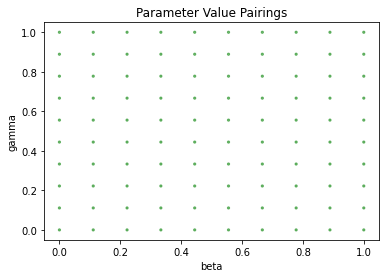

In [9]:
# Plot "true/false" points.  

sir_model.plot_two_params("beta", "gamma", param_choices_true_false)